# Counter-Strike and Game Theory: A foray into Statistical Analysis and Modelling

## Counter-Strike

Counter-Strike is a popular online first person shooter franchise. The latest installment: CS: Global Offensive (referred to hereon as CS:GO) has sold 25 million copies alone.

"Counter-Strike is an objective-based, multiplayer first-person shooter. Two opposing teams—the Terrorists and the Counter Terrorists—compete in game modes to complete objectives, such as securing a location to plant or defuse a bomb. At the end of each round, players are rewarded based on their individual performance with in-game currency to spend on more powerful weapons in subsequent rounds. Winning rounds results in more money than losing, and completing objectives such as killing enemy players gives cash bonuses." - _Wikipedia_ [[1](https://en.wikipedia.org/wiki/Counter-Strike)]

In game theory terms, CS:GO is a stochastic game consisting of between 16 and 30 subgames. The only parameter which passes from one round to the next is the net worth of each team. Since these rounds are both discrete and stochastic, this problem is an example of a Markov Chain [[2](https://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/Chapter11.pdf)].

Not only is the game hugely popular with casual gamers, it also has immense appeal as an _E-sport_. As the website _E-Sports Earnings_ notes: the total prize pool since CS:GO's release in 2012 has totalled over $68,00,000.00, second only to that of _DOTA 2_. [[3](https://www.esportsearnings.com/)]

Predicting the outcome of competitions is a lucrative business for both bookies and bettors alike and CS:GO is no exception. According to a report cited in the _Washington Post_, global E-Sports betting is expected to total almost $7 billion in 2018. [[4](https://www.washingtonpost.com/sports/esports-bookmaking-globally-its-already-a-billion-dollar-gambling-industry/2018/04/06/be89c282-2b99-11e8-8688-e053ba58f1e4_story.html?noredirect=on&utm_term=.1284c20eac45)]

## Objectives

This report aims to explore and analyse _CS:GO_ through the use of statistical analysis and the creation of predictive models. We will use some classification models included in the popular Python module _Scikit-Learn_ as well as creating our own. Throughout this I will test hypotheses and briefly discuss of the significance of each result. 

## Our data

Our data, 'esea_meta_demos.part1', was downloaded from the online dataset provider, Kaggle [[5](https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage)]. The data is by the parsing of 'demos', digital recreations of matches that are available online. These are perfect for modelling since they contain all the salient information about the game state and update 64 times per second. 

I have chosen to analyse the game from an inter-subgame basis, that is, round-by-round. As such, we will be using the 'meta_demos' file, which describes each round according to a few key statistics such as equiptment values, which map the game was recorded on, which match the game belongs to, which round it is and of course which team won the round.        

## A quick primer on CS:GO's in-game economy

At the beginning of a round, players have the opportunity to purchase weapons and equiptment. As one may expect, more expensive weapons and equiptment are, generally, more powerful and yield in-game advantages to a player. We will later observe this effect graphically.   

The equiptment and weapons bought by a team in a round is nicknamed the 'buy' and is co-ordinated by a team in order to maximise their expected value (i.e rounds won). Crucially, teams will not always spend the maximum amount since this is not always the most effective long-term policy. 

The first round (of either half, hereon referred to as such) begins with a balanced economy. Each player is granted a fixed sum of cash to spend on weapons and equiptment. The cash value is extremely limited such that players can _only_ afford 
pistols and/or limited equiptment, hence, this round is known as the "pistol round". 
  
The round following the pistol round tends to be largely one-sided. This is the result of the economic mechanics of the game allowing one team to essentially buy a much more powerful array of weaponry and equiptment than their opponents. 

After one team has won a round, they have a short period of time within which to scavenge better equiptment from the bodies of their fallen teammates/ opponents. (Consequently, winning a round does not have a static economic 'reward') 

Let's explore the data. 

In [3]:
%matplotlib notebook
%matplotlib notebook

import pandas as pd
from numpy import shape, array, pi, random
import time
from matplotlib.pyplot import *  # this removes the need to call matplotlib as 'plt'
import sklearn, sklearn.neighbors
import scipy as sp
import numpy as np
from numpy import array, arange, linspace, logspace
from tqdm import tqdm # This module allows us to track the completion of lengthly iterative processes.
import warnings
warnings.filterwarnings('ignore')

style.use('fivethirtyeight')
style.use('ggplot')

In [5]:
cs_file_path = "esea_meta_demos.part1.csv"
cs_data = pd.read_csv(cs_file_path)

print(np.shape(cs_data))
cs_data.head()

(215919, 10)


,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Hentai Hooligans,Terrorist,PISTOL_ROUND,4300,4250
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Hentai Hooligans,Terrorist,ECO,6300,19400
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Hentai Hooligans,Terrorist,SEMI_ECO,7650,19250
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Hentai Hooligans,Terrorist,NORMAL,24900,23400
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,Animal Style,CounterTerrorist,ECO,5400,20550


Because Counter Strike is an assymetrical game, each map will generally favour one side to some degree. Let's see which map is the most 'balanced' - that is to say the map with closest to no difference in win percentage for either CT or T side.

Let's use our data to list the maps in order of how balanced they are. 

In [3]:
def get_winners_percentage(map_to_test, df):
    map_data = df[cols].loc[df['map'] == map_to_test]
    ct = 0.0
    t = 0.0

    for index, row in map_data.iterrows():
        if (row['winner_side'] == 'Terrorist'):
            t+=1
        else:
            ct+=1
    total = int(t + ct)
    t_percent = float((t/total) * 100)
    ct_percent = float((ct/total) * 100)
    return round(ct_percent, 2), round(t_percent, 2), ct, t # return the win%'s as well as total round wins: ct%,t%,ct,t


# defining the columns which will be used
cols = ['file', 'map', 'round', 'round_type', 'winner_side']
# list the maps included in the .csv file
map_names = 'de_overpass', 'de_mirage', 'de_dust2', 'de_cache', 'de_inferno', 'de_cbble', 'de_train'

li = []
[li.append((name, get_winners_percentage(name, cs_data))) for name in map_names]

def absolute_difference(elem):       # function for calculating the difference in win% by side
    return abs(elem[1][0]-elem[1][1]) 

li.sort(key=absolute_difference)     # ordering our maps by how balanced the win%'s suggest they are

print('In Descending Order of Balance, win percentages:\n\n\t\tCT\t T:\n')
[print('{}: \t{}%\t {}%'.format(elem[0], elem[1][0], elem[1][1])) for elem in li]
Out = None

In Descending Order of Balance, win percentages:

		CT	 T:

de_mirage: 	49.97%	 50.03%
de_overpass: 	51.67%	 48.33%
de_cbble: 	47.98%	 52.02%
de_cache: 	47.45%	 52.55%
de_inferno: 	47.4%	 52.6%
de_train: 	52.93%	 47.07%
de_dust2: 	45.66%	 54.34%


#### It seems that the most balanced map is Mirage! 

Since each map encourages different playstyles and strategies, any analysis of trends will generally be map-dependent. We will therefore hereon be using data collected from matches played on the map __de_mirage__. Where possible, I have included map as a function parameter. 

Having the same number of samples of each classification is important for classification models so choosing a sample of our data with very similar sizes (rounds won by T those won by CT) will yield the additional benefit of not having to resample our data to achieve absolute parity in sample size for each classification. That is to say, we will knowingly accept the extremely minor sample bias of there being more T wins than CT wins. If we had chosen a map where the win percentage was skewed to a much larger degree, i.e 60%-40% there would potentially arise issues with our classification models. This essentially side-steps the problem of 'class imbalance' which in the words of B. Das et. al _"Restrict[s] the application of conventional classifiers directly on the data"._ [ https://www.eecs.wsu.edu/~cook/pubs/icdm13.2.pdf ]

In [4]:
def roundwins(map_):
    CT, T = get_winners_percentage(map_, cs_data)[-2:]
    print('Total round wins on de_mirage:\nCT: {:.0f} T: {:.0f}'.format(CT, T))
    return CT, T
# this function can be called for any map.
# if the argument passed is a map name which doesn't exist in the .csv file a Divison by Zero Error will occur

roundwins('de_mirage')
Out = None

Total round wins on de_mirage:
CT: 37935 T: 37987


# Modelling

Let's define our target variable. 
We wish to predict the winner of a round given our access to data about the game up until the beginning of said round.

Our target variable is thus who wins the round, defined in our .csv file as the 'winner_side' column. 

Perhaps the most simple technique we can apply to our data is the __Persistence Model.__

Also known as _Naïve forecasting_ or _Random Walk Forecasting_ the persistence model is simple model for predicting time-series data. 

# Persistence model:
##### "given that the result of a round is linked to the result of the previous round, this model predicts the result of round n+1 to be the same as round n."

One way to test the usefulness of our subsequent models is to see if it can provide better predictions of a round's outcome than a persistence model can. In this sense, we are using the Persistence model (PM) as our __baseline.__

### Hypothesis:
The persistence model will have a __different classification accuracy__ in each half of the game.

Reasons for this prediction: 

Psychological effects such as _tilt_ (frustration) and mental fatigue affect players worse as the game progresses. Thus, a lost round would potentially having a more significant negative effect on a team's morale in post halftime rounds than in the former half of the match. If this hypothesis were correct, in the absence of other effects, we would observe that the PM would have a higher accuracy in the post halftime rounds. 

That is to say, the effect losing a round has on the outcome of the next round is exaggerated by the psychological aspect of the defeat to a _larger degree_ later in the match. 

__Further Work:__ An additional hypothesis is that lower-skilled players become more frustrated by a loss and experience the above psychological effects to a signficantly higher degree than a professional or semi-professional player, who will be able to stay level-headed. One could test to see whether or not the PM performs better in matches amongst lower rated players than professional players. If this hypothesis were true, one would observe a gradual decrease in forecastability as rating bracket increases. 

### Let's test the Persistence Model on the First Halves of our matches

The code for the PM follows a somewhat convoluted logic; certainly it's much more complex than one might expect from a seemingly trivial model. For each row in the dataframe, the model needs to evaluate and perform several things: 

1) Is this a new match? - If not, there is no prediction to evaluate. Importantly, we will still want to update our variable 'prevresult' for the purpose of evaluating the prediction when we iterate through the next row. 
    
    y: set the gamefile to row['file'], set prevresult to None
    n: execute model evaluation            

2) Is this round in the second or first half of the match? - This logic gate decides which variables (firsthalf/secondhalf) will be updated. 

3) Is the model prediction of the result of this round, 'prevresult' equal _None_? 
    
    n: pass
    y: If so, did this model _successfully_ predict the result of this round?
        y/n: update variables to reflect this result
4)  If the row isn't 15*:

    prevresult = result

*(the final round of the first half, which we do not use to predict the result of round 16 due to the in-game economy being reset) 

In [6]:
def loadmap(mapname):
    cs_data = pd.read_csv(cs_file_path)
    cols = ['file', 'map', 'round', 'winner_side', 'ct_eq_val', 't_eq_val']
    cs_data = cs_data[cols].loc[cs_data['map'] == mapname]
    return cs_data

cs_data1 = loadmap('de_mirage')
# since we're using the map mirage, we can define a new pandas df

def persistencemodel(df):
	gamefile= None
	prevresult= None
	true1, true2, false1, false2, firsthalf, secondhalf = 0,0,0,0,[],[]
	for index, row in df.iterrows():
		if gamefile == row['file']:
			if prevresult != None:
				
				if row['round'] <16:
				
					if prevresult == row['winner_side']:
						true1 += 1
						firsthalf.append(1)
					else:
						false1 += 1
						firsthalf.append(0)
				elif row['round']>16:
					if prevresult == row['winner_side']:
						true2 += 1
						secondhalf.append(1)
					else:
						false2 += 1
						secondhalf.append(0)
			else:
				pass
            
			if row['round'] != 15:
				prevresult = row['winner_side']
			else: prevresult = None
		
		else:
			gamefile = row['file']
			prevresult = None

	return true1/(true1+false1), true2/(true2+false2), firsthalf, secondhalf
    # this can be done without the true and false variables

accuracy_1, accuracy_2, firsthalf, secondhalf = persistencemodel(cs_data1)

print("Persistence model accuracy in the first  half: {:.3f}%\nPersistence model accuracy in the second half: {:.3f}%"
      .format(accuracy_1*100, accuracy_2*100))

Persistence model accuracy in the first  half: 65.485%
Persistence model accuracy in the second half: 66.477%


### Result:

The Persistence model appears to classify approximately as accurately (<1% difference) in both halves. At first one might interpret this as the model having the _same_ accuracy on both populations. This is however a claim which we should be weary of making simply on the basis of the small accuracy delta between populations. Each of our samples is large enough (n $\approx$ 40,000) that if they were drawn from the same population they ought to appear close to identical.  

## Statistical Analysis

### T-test

The T-Test is a statistical test to test the independence of two sets of data. In this case our data are: 'firsthalf' and 'secondhalf'; lists of binary digits with 1's corresponding to correct model predictions and 0's corresponding to incorrect predictions. 

We can use tests like this to determine the likelihood our hypothesis is correct.

__Note:__ Importantly, the t-test assumes the predictor variable/s to be approximately normally distributed. Since our data is binary in nature, this stipulation is somewhat moot.  

To reiterate: we predicted that our PM would have a higher accuracy in the latter half of the game, which would be proven if the difference in model accuracy on each sample proved to be statistically significant: (null hypothesis __p > 0.95__). 

The Null hypothesis is: "The persistence model is __equally__ accurate on both samples." 

If the Null hypothesis is correct, then the model accuracies ought to be equal, with the $\approx$ 1% difference in reported accuracy explained away as statistically insignificant variance.  

Since the t-test accuracy is contingent on the size of the samples, let's plot the likelihood of the Null hypothesis being correct if we slice our _firsthalf_ and _secondhalf_ arrays down to length 'i'. By plotting the t-test probability value against _i_, we can see the probability tending towards zero. We can reasonably infer through extrapolation that the Null Hypothesis is false extremely likely to be false, and our hypothesis holds true. This is an example of _Bayesian Convergence_, where the likelihood of our supposition being false tends exponentially towards zero as we include more samples. View the graph below for a graphical demonstration of this property

The PM does indeed seem to be better at predicting rounds in the second half of the match than the first. 

We noted that the t-test assumes an approximately normal distribution in the sample data - what if this assumption were false?

### Mann–Whitney U test

Unlike the t-test, the MWU test does not require the assumtion that the variables approximately normal distributions.

<IPython.core.display.Javascript object>


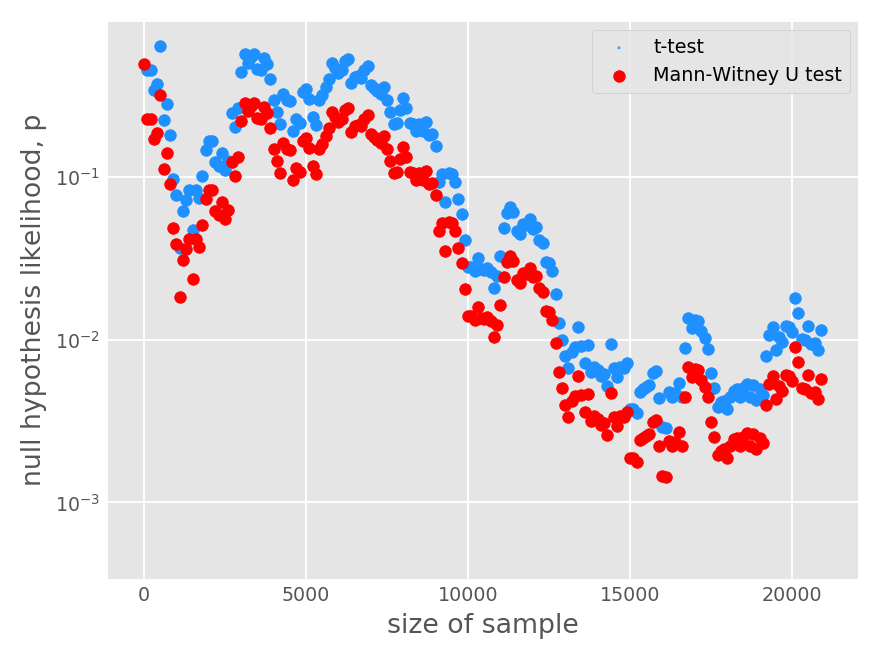

In [7]:
%matplotlib notebook
from scipy.stats import ttest_ind

figure()
# print((71897*(1-0.6553666651474409)**2)/108705)
# print((53667*(1-0.6655711681321543)**2)/80633)



for i in range(1, 21000, 100):
    if i==1:
        label = 't-test'
    else:
        label = None
    scatter(i, ttest_ind(firsthalf[:i], secondhalf[:i], equal_var=False)[1], label=label, color='dodgerblue')
    # We don't know the variance of the samples so equal_var = False

yscale('log') 
ylabel('null hypothesis likelihood, p', fontsize= 14)
xlabel('size of sample', fontsize= 14)
legend()
tight_layout()
show()

In [8]:
from scipy.stats import mannwhitneyu

for i in range(1, 21000, 100):
    if i==1:
        label = 'Mann-Witney U test'
    else:
        label = None
    scatter(i, mannwhitneyu(firsthalf[:i], secondhalf[:i])[1], label=label, color='red' )

legend()
Out = None

In [8]:
print('Number of rounds in our sample\nfirst half: {}\nsecond half: {}\n'.format(len(firsthalf), len(secondhalf)))
print('U-test null hypothesis p-value:',mannwhitneyu(firsthalf, secondhalf)[1])
print('t-test null hypothesis p-value:',ttest_ind(firsthalf,secondhalf, equal_var=False)[1])

Number of rounds in our sample
first half: 38714
second half: 28160

U-test null hypothesis p-value: 0.00377366703734
t-test null hypothesis p-value: 0.00747988471708


### Conclusion

Persistence model accuracies in the first and second half were 65.49% and 66.48%; the distributions in the two groups differed significantly. (Mann–Whitney U = 539686240, n1st = 38714 rounds n2nd = 28160 rounds, P < 0.0038)

That is to say, the likelihood of the null hypothesis being true is 0.38%, and the probability that our hypothesis of different model accuracies is over 99%.

### Interpretation

While we've shown it to be very likely that our model does indeed have a higher accuracy at predicting second-half rounds, the difference in accuracy is small enough to ignore for the most part when making any human analysis. 

I suspect that model accuracy is much more dynamic than our Hypothesis gives credit. That is to say: I imagine the model accuracy changes moderately on a round-by-round basis, rather than (only) a half-by-half one.  

Despite this result, investigating model accuracy under different conditions and on different samples is worthwile. If we were to ultimately aggregate each of our model's prediction this information would be helpful in 'weighting' each model's vote. 

For heightened accuracy this ought to be done dynamically, according to _n,_ the current round of the match.

## Let's Investigate how Persistence model accuracy evolves over time

In [10]:
def new_persistencemodel(round_, df=cs_data):
    data = df.loc[(df['round'] == round_) | (df['round'] == round_-1)]
    # ' | ' means 'or'
    prediction = None
    modelresult = []
    for index, row in data.iterrows():
        if row['round']== round_:
            if prediction == row['winner_side']:
                modelresult.append(1)
            else:
                modelresult.append(0)
        else:
            prediction = row['winner_side']
    return sum(modelresult)/len(modelresult)

frst, scnd = [], []
for i in range(2, 15):
    #print(new_persistencemodel(i))
    frst.append((i ,new_persistencemodel(i)))
    
for i in range(17, 30):
    #print(new_persistencemodel(i))
    scnd.append((i ,new_persistencemodel(i)))

<IPython.core.display.Javascript object>


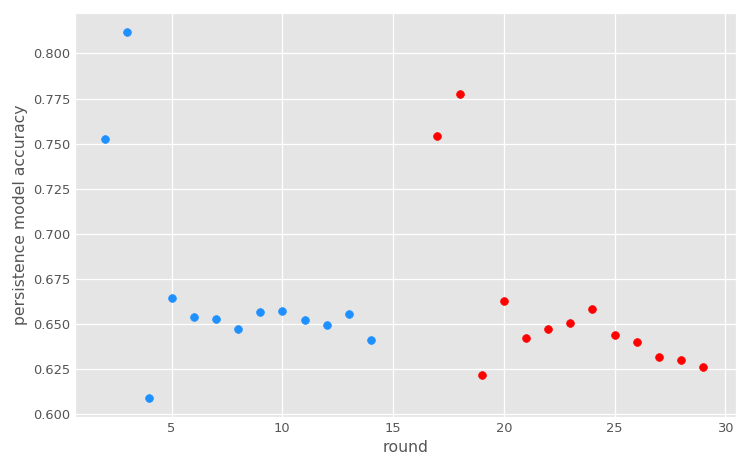

In [60]:
figure(figsize=(8, 5))
for i in frst:
    scatter(i[0], i[1], color='dodgerblue')
for i in scnd:
    scatter(i[0], i[1], color='red')
    
ylabel('persistence model accuracy')
xlabel('round')
#legend()
tight_layout()

<img src="csgo flowchart.png">

The accuracy of the PM naturally ebs and flows over the course of a match; in large part, this can be explained by looking at the economic circumstances created by the aforementioned round favouring that team to varying degrees over the course of a game. In the absence of any psychological effects; the subgames of CS:GO (rounds) is an example of a Markov Chain[] whose probabilities are dynamic with respect to the current round.

## What does this tell us?

PM accuracy is essentially a measurement of how dependent the result of round n is on round n+1; accuracy on a round demonstrates that the previous round is of corresponding importance.

__note:__ It may be more intuitive to plot the _predictive_ accuracy of round n, rather than the _accuracy_ on round n+1  

### Our hypothesis was flawed!

We posited: 'The persistence model will have a __different classification accuracy__ in each half of the game.' which we claimed might indicate that human frustration would result in skewed rounds, where the advantages accrued would be psychologically exaggerated. We failed to account for the varying number of rounds within a match. __The first team to win a total of 16 rounds wins the match; whether the opponents won 1 or 14 rounds__. (15-15 is a draw). Hence, the first 15 rounds of a match will _always_ be played, whereas the 15 in the second half will not. 

Our statistic 'Persistence Model Accuracy Second Half' is misleading because there are __disporportionately__ more rounds in our dataset in the 16-20 region than the 21-30 region. This skews the result of this statistic immensely to the point at which it is somewhat misleading. A glance over the PM model accuracies by round exemplifies this. On average each point is below its respective round in the first half, yet the _mean_ accuracy accross all rounds in the second half is higher.  

To demonstrate this graphically let's overlay the plots. 

<IPython.core.display.Javascript object>


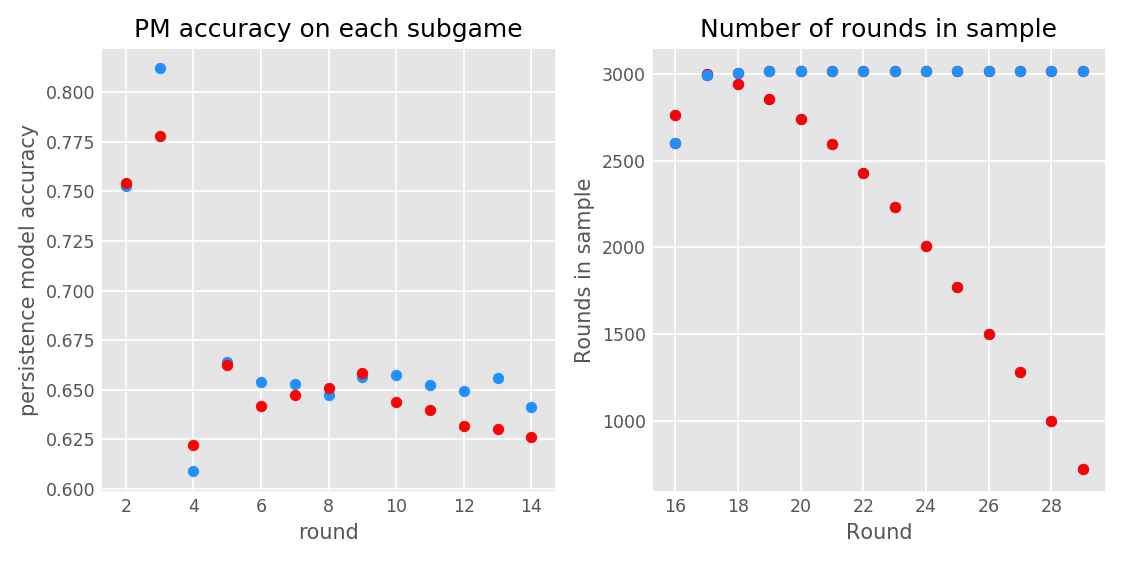

In [481]:
figure(figsize=(9,4.5))
subplot(121)
for i in frst:
    scatter(i[0], i[1], color='dodgerblue')
for i in scnd:
    scatter(i[0]-15, i[1], color='red')
title('PM accuracy on each subgame')
ylabel('persistence model accuracy')
xlabel('round')
tight_layout()

In [474]:
W = []
for i in range(16,30):
    data = cs_data.loc[(cs_data['round'] == i)]
    W.append(data.shape[0])
print(W)

[2764, 2999, 2943, 2852, 2741, 2594, 2430, 2231, 2006, 1770, 1502, 1282, 1004, 725]


In [483]:
subplot(122)
title('Number of rounds in sample')
xlabel('Round')
ylabel('Rounds in sample')
tight_layout()

for i in range(16,30):
    data = cs_data.loc[(cs_data['round'] == i)]
    scatter(i, data.shape[0], color='red')
for i in range(1,15):
    data = cs_data.loc[(cs_data['round'] == i)]
    scatter(i+15, data.shape[0], color='dodgerblue')

This discovery of a huge and troublesome skew in our sample is inconveniently late, as it renders our 

### Not all round wins are _worth_ the same!

As we hypothesised previously, the first round of each half is an exceptionally good predictor of the following round with an accuracy of $\sim$ 10% higher than on the sample as a whole. It follows thus that pistol rounds are quantifiably more important than other rounds.    

Unexpectedly, the _second_ round of a half proved to be an even stronger predictor than the first, which breaks the assumption that the pistol round is neccesarily the most important round in the half. Winning the next round is - at best- a crude measurement of how important a round is. 

__Further Work:__ A better measurement would be the team's chances of winning the half after achieving a win in the first and second rounds. 

### Reflections

The PM is, in theory, a suboptimal way to analyse this markov chain for the simple reason that it doesn't fully encapsulate the present game state. 

The only in-game parameter passed from subgame to subgame is the cash balance of each team - something our dataset unforunately doesn't include. An _ersatz_ for this data is _net worth_. The distinction being that the first contains information about the _range_ of 'buys' the team could employ while the second contains only information regarding the 'buy' strategy they opted for. This isn't a critical distinction. 

__Note:__ In practice, our 'ersatz' data is actually a more useful predictor in some ways than the 'pure' data. The reason for this is that often teams will commit to a buy strategy that while suboptimal in the current subgame that conserves a portion of their resources for later rounds. An example of this is the 'eco' (economical) buy strategy. The buy strategy chosen is of course a better predictor than the range of strategies at predicting the result of a single round. 

The reason the PM is inordinately good at predicting the 2nd and 3rd rounds is that it is in effect conveying information about the economic state of the game. The rapid tapering off of this accuracy reflects the increasing dilution of this information. This is explained by the game's comeback mechanics (economic boost for teams that lose multiple rounds consecutively).

For example, if a team loses a later round but have a sufficiently large cash balance remaining, their winning chances in the subsequent round is affected relatively little compared to in early rounds where they have not had an opportunity to accrue such a balance. This gradual dilution is reflected in the downwards trend in model accuracy. Put succinctly, The more rounds there has been the less useful the winner of the previous round is as a predictor.

## Quantifying economic advantage

In [107]:
%matplotlib notebook
def winningchances_nw_gap(nbins, testmap='de_mirage'):
    
    cs_data = pd.read_csv(cs_file_path)
    cs_data = loadmap(testmap)
    cs_data['nw difference'] = cs_data['ct_eq_val'] - cs_data['t_eq_val']

    #bins = np.linspace(-45000, 45000, 10)
    binnumbers = np.arange(0,nbins,1)
    #binnumbers = np.arange(0,20,1)
    #bins = pd.cut(cs_data['nw difference'], bins=100, retbins=True)
    cs_data['binned'] = pd.cut(cs_data['nw difference'], bins=nbins, labels=binnumbers)

    winpercent = []
    for i in tqdm(range(nbins)):
        t, total = 0, 0 
        for index, row in cs_data.iterrows():
            if row['binned'] == i:
                if row['winner_side'] == 'Terrorist':
                    t +=1
                    #print(t)
                else:
                    pass
                total +=1
        try:  
            #print(t/total)
            winpercent.append(t/total)
        except ZeroDivisionError:
            #print(0)
            winpercent.append(0)
    #figure()
    plot(binnumbers[10:90], winpercent[10:90])
    show()
    print(testmap)
    return binnumbers, winpercent
    
binnumbers, winpercent = winningchances_nw_gap(100)

<IPython.core.display.Javascript object>


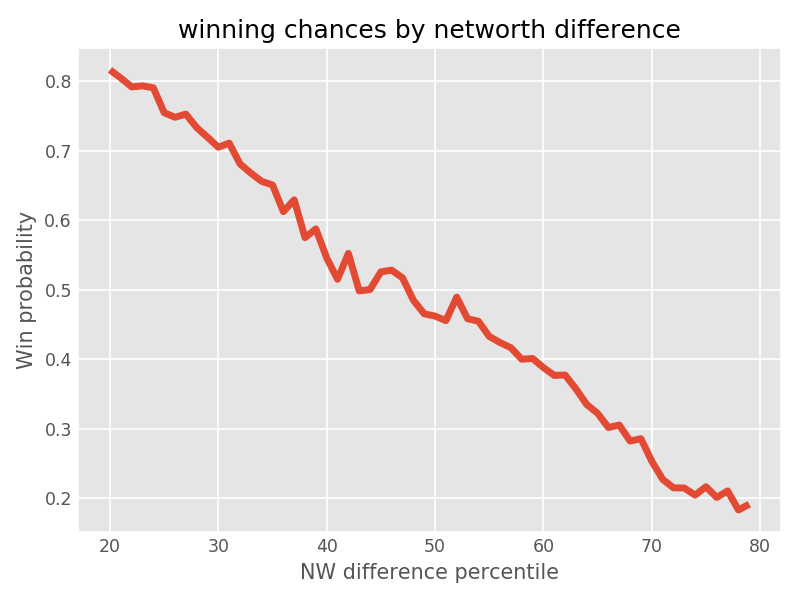

In [108]:
figure()
plot(binnumbers[20:80], winpercent[20:80])
title('winning chances by networth difference')
ylabel('Win probability')
xlabel('NW difference percentile')
tight_layout()
show()

# K-Nearest Neighbor's Algorithm

The K-Nearest Neighbor's Algorithm is a classification model which seeks to predict a sample's classed based on the class identity of the sample's _K_ closest points within the training data. The diagram below is an example of a two class NNA model with K = 3. In cases where the class of the nearest neighbors are not unanimous, each of the neighbor's 'vote' on the most likely class. In the example below, there are two votes for class B and only one for class A, so the model predicts class B. 

While the K-NNA can be applied to data with any number of dimensions, model accuracy suffers in higher-dimensions. In the words of Vladimir Pestov from the University of Ottowa:

_"The number of datapoints required to maintain the consistency of the algorithm must provably grow
exponentially with the dimension of the domain."_ [[6](https://arxiv.org/pdf/1110.4347v2.pdf)]

It is for this reason that Principal Component Analysis is often used to reduce the dimensionality of data as a form of pre-processing. [[7](https://www.academia.edu/30642706/Usage_of_Principal_Component_Analysis_PCA_in_AI_Applications)]

<img src="K-NNA.png">

We discussed _net worth_ and it's critical importance in making predictions. By comparing subgames to those with the most comparable economic paramaters, CT and T _net worth_, we are able to make reasonably accurate predictions for which team will win a given round.

Let's thus use the K-NNA algorithm and train it using the equiptment values of the _current round_ to see how reliable a predictor this variable is. 

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import axvline
from sklearn.model_selection import train_test_split
from random import seed
from scipy.optimize import curve_fit

In [19]:
cs_data = loadmap('de_mirage')
# The map we decided to model
equiptment_vals = ['ct_eq_val', 't_eq_val'] 
# These are the variables we will use in our model

<IPython.core.display.Javascript object>


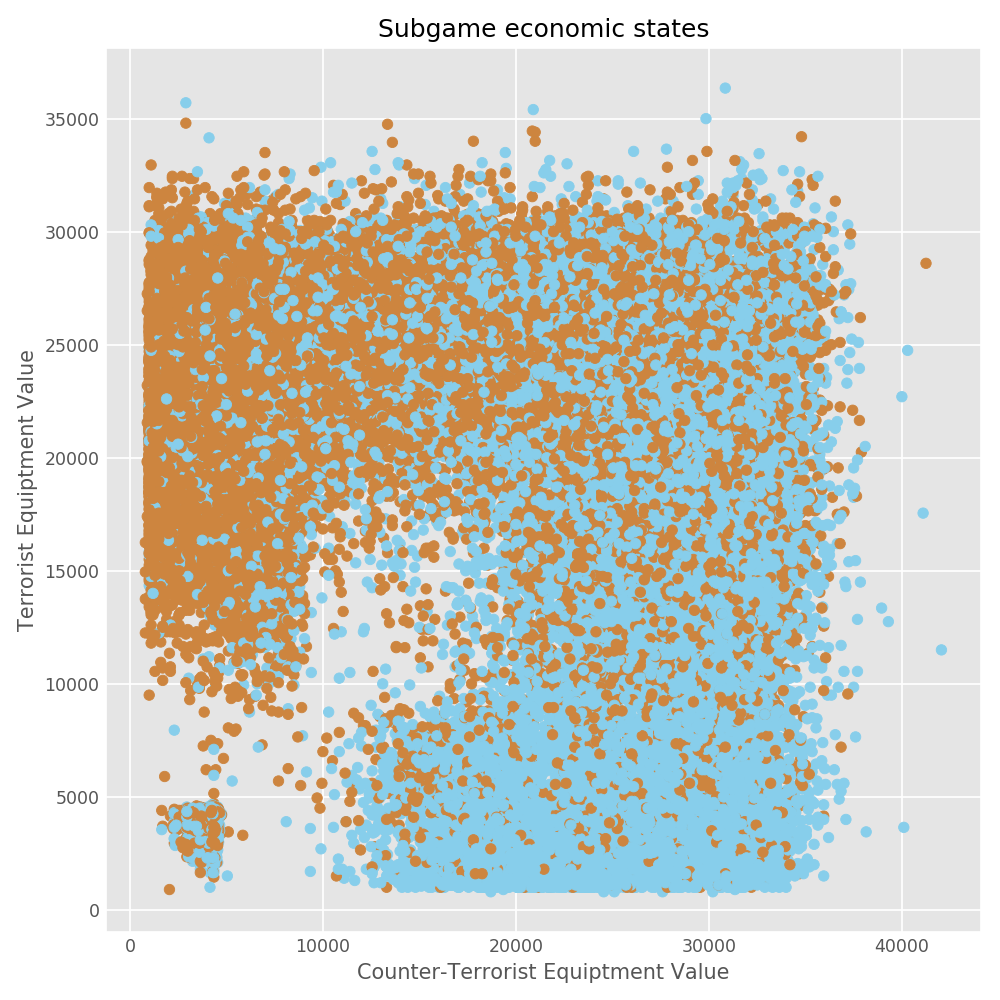

In [56]:
def testtrain_split(df, cols = ['ct_eq_val', 't_eq_val']):
    X_data = df[cols] 
    X_train, X_test, y_train, y_test = train_test_split(X_data,
        cs_data['winner_side'], random_state=1) 
    # we manually define random_state so that our results are reproduceable
    
    return 

testtrain_split(cs_data)

win_train = y_train.copy()
win_train[y_train == 'Terrorist'] = 'peru'
win_train[y_train != 'Terrorist'] = 'skyblue'

figure(figsize=(8, 8))
title('Subgame economic states')
xlabel('Counter-Terrorist Equiptment Value')
ylabel('Terrorist Equiptment Value')
scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=win_train)
tight_layout()

Brown dots are samples where Terrorists won, and Blue those where CT's won.

We can clearly see that, at least on average, the team with the economic advantage will win any given round. Also note the decreasing uncertainty in this observation at the upper left and lower right extremeties where either team has a very large advantage. 

### Discussion on Markov Chains and an idealistic model

The pinnacle of statistical modelling of subgames of _CS:GO_ would be a markov chain whose probabilities we knew; essentially mapping out the probability of the game state reaching any point on the above graph given it's current location. It would be unncessary to model this completely, rather it could more efficiently be done by considering the probability of moving from one _region_ of states to another as opposed to enumerating the extremely large number of game states. 

Our modelling centers around modelling the win/loss result of one subgame. A Markov Model would also include the likelihood of different economic consequences occuring. 

The completion of a Markov Model would allow for much more wholistic and cohesive predictions as to the likelihood of one team winning a match.

In [21]:
def NNA(X_train, kmin = 1, kmax = 250, stepsize = 20):
    start = time.time()
    accuracy, neighbors = np.array([]), np.array([])
    for i in range(kmin, kmax, stepsize):
        knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
        knn.fit(X_train, y_train)
        accuracy = np.append(accuracy, knn.score(X_test, y_test))
        neighbors = np.append(neighbors, i)
    end = time.time()
    return accuracy, neighbors, 100*max(accuracy), neighbors[np.argmax(accuracy)], end - start,

In [22]:
cs_data = loadmap('de_mirage')

In [54]:
def testtrain_split(df, cols = ['ct_eq_val', 't_eq_val']):
    X_data = df[cols] 
    X_train, X_test, y_train, y_test = train_test_split(X_data,
        cs_data['winner_side'], random_state=1) 
    # we manually define random_state so that our results are reproduceable
    return X_train, X_test, y_train, y_test
    # we define this function such that we can easily reset our Test Train split

X_train, X_test, y_train, y_test = testtrain_split(cs_data)

accuracy, neighbors, maxaccuracy, bestneighbors, runtime = NNA(X_train, kmax = 250, stepsize = 10)
print(f'Maximum accuracy: {maxaccuracy:.2f}%\nComputational time: {runtime:.2f}\nOptimal K-NN: {bestneighbors:.0f}')

Maximum accuracy: 67.23%
Computational time: 13.22
Optimal K-NN: 241


<IPython.core.display.Javascript object>


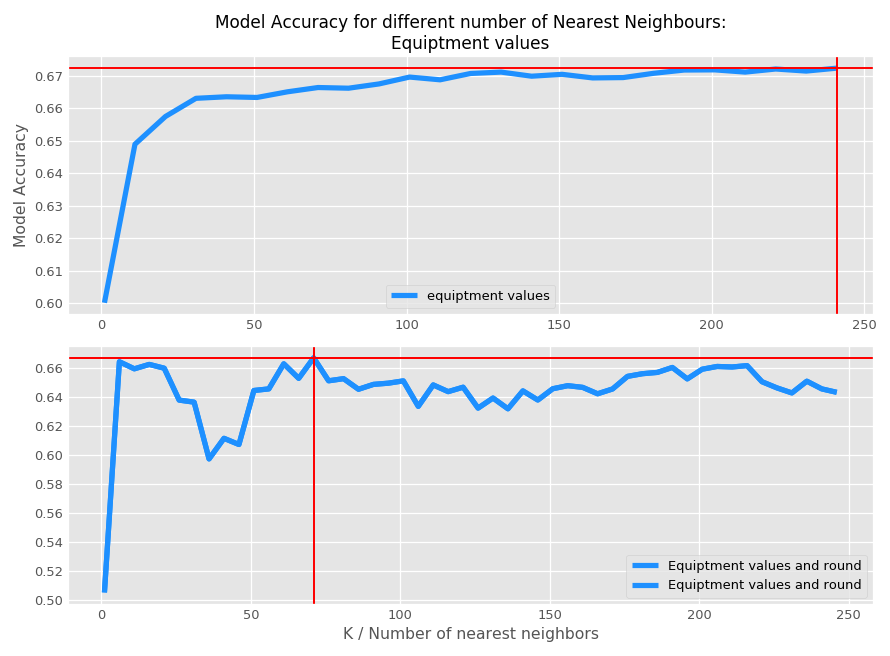

In [62]:
%matplotlib notebook
figure(figsize=(9.5,7))
subplot(211)
#figure(figsize=(9, 4))

title('Model Accuracy for different number of Nearest Neighbours:\nEquiptment values',size=13)
plot(neighbors, accuracy, color='dodgerblue', label='equiptment values') 
axvline(neighbors[np.argmax(accuracy)], color='red', linewidth= '1.5')
axhline(max(accuracy), color='red', linewidth= '1.5')
ylabel('Model Accuracy')
legend()
tight_layout()
Out = None

Let's see if adding an additional data series, 'round' to our X_train data improves our model.

In [36]:
def weighting(param, multiplier):
    round_equiptment_vals = ['ct_eq_val','t_eq_val','round']
    X_data = cs_data[round_equiptment_vals]

    X_train_1, X_test, y_train, y_test = train_test_split(X_data, cs_data['winner_side'], random_state=1 )
    print(shape(X_train), shape(y_train))

    X_train_1['round'] = X_train_1['round']*multiplier
    return X_train_1, X_test, y_train, y_test
    
X_train_1, X_test, y_train, y_test = weighting('round', 15000)
# The weighting paramater ought to be tuned.

(56941, 2) (56941,)


In [37]:
accuracy1, neighbors1, maxaccuracy1, bestneighbors1, runtime1 = NNA(X_train = X_train_1, kmax = 250, stepsize = 5)
print(f'Maximum accuracy: {maxaccuracy1:.2f}%\nComputational time: {runtime1:.2f}\nOptimal K-NN: {bestneighbors1:.0f}')

Maximum accuracy: 66.69%
Computational time: 33.43
Optimal K-NN: 71


In [64]:
subplot(212)
#title('Model Accuracy for different number of Nearest Neighbours:\nEquiptment values and round',size=13)
plot(neighbors1, accuracy1, color='dodgerblue', label='Equiptment values and round')
axvline(neighbors1[np.argmax(accuracy1)], color='red', linewidth= '1.5')
axhline(max(accuracy1), color='red', linewidth= '1.5')
xlabel('K / Number of nearest neighbors')
legend()
tight_layout()
Out = None

Clearly, it seems that using the 2 dimensional data, equiptment values provides better model accuracy as K tends towards the sample size. However, that's not to say that _round_ does not benefit the model whatsoever- in fact the model trained off of the data including round and equiptment values performed better for low values of K. 

## K-Nearest Neighbors for _continuous_ prediction

Given visual analysis of the Equiptment Values plot, one might conclude that a simple classification prediction is insufficient at conveying the probabilistic nature of what we are attempting to model. Take for example the region around the _y = x_ line, where uncertainty is highest: the class prediction will have a very high uncertainty in this region. Returning a single class for such noisy data is somewhat misleading- instead we ought to output the _probability_ of a sample belonging to one class.

### Hypothesis:
If we can extract the _votes_ of the nearest neighbor's of a sample, they ought to give us some communicable insight into how likely a particular class is in that region of gamestates. 

I predict that we will be able to directly interpret the distribution of votes as a probabilistic approximation of a test sample's result!

### The problem with probabilistic predictions
How can we test such a hypothesis? A model that predicted results on a _continuous_ (0-100%) scale would most require a truly huge amount of data to even begin to determine it's predictive accuracy* . We can solve this problem by grouping our predictions. For example: rounds for which our model predicts a 0-10% chance of CT victory ought to produce that result a corresponding portion of the time.  

_*the number of predictions is in fact limited by the number of economic states, which while very large is finite._


### Parsing this information from _sk-learn's_ K-NN Algorithm

Sk-learn's K-NN Algorithm suprisingly does not return the nature of the votes, rather the index of each nearest neighbor. These indices are the second output of the 'model_name.kneighbors' and we access them as follows:

        'knn.kneighbors([economy])[1]'
        
We can then find the votes by sorting through our _y_data_ using pandas' index-location (iloc) feature.

Below is an example where we find the predicted win percentage for the game state where each team has $30,000. 

In [68]:
# we intentionally perform this outside of our function because otherwise it would run every time our loop did,
# i.e for each sample in X_train 
testtrain_split(cs_data)
knn = KNeighborsClassifier(n_neighbors=1000, n_jobs=-1)
knn.fit(X_train, y_train)
# creating our model. 


# testing
indeces = knn.kneighbors([[30000, 30000]])[1] 
# the input array is ['ct_eq_val', 't_eq_val']

votelist = []
for i in indeces:
    a = y_train.iloc[i]
    b = list(a)
    votelist.append(b)
    
    # votelist is currently a list of lists, which is not useful.
    votelist = votelist[0]


Count = votelist.count('CounterTerrorist')
print('Expected Counter Terrorist win probability: {}'.format(Count/len(votelist)))

Expected Counter Terrorist win probability: 0.534


### Creating a model
Win_estimator accepts the economic game state as it's paramaters and returns the expected probability that Counter-Terrorists win that subgame.

In [70]:
def win_estimator(ct_eq_val, t_eq_val):
    
    economy = np.array([ct_eq_val, t_eq_val])
    indeces = knn.kneighbors([economy])[1]
    
    
    votelist = []
    for i in indeces:
        a = y_train.iloc[i]
        b = list(a) 
        votelist.append(b)

        # votelist is currently a list of lists, which is not useful.
        votelist = votelist[0]
    
    Count = votelist.count('CounterTerrorist')
    CTwinprob = Count/len(votelist)
    return CTwinprob
    
CTwinprob = win_estimator(20000, 10000)
print(f'Expected Counter Terrorist win probability: {CTwinprob}')

Expected Counter Terrorist win probability: 0.688


### Testing our model
Let's evaluate how accurate this our continuous model is. First we will have to evaluate our model on X_train and add a new series to X_train's dataframe: 'CT win probability estimate'. 

In [79]:
newseries = np.array([])
# np arrays use less memory than lists. 

with tqdm(total=len(list(X_test.iterrows()))) as pbar:
        for index, row in X_test.iterrows():
            newseries = np.append(newseries, win_estimator(row['ct_eq_val'], row['t_eq_val']))
            pbar.update(1)

print(newseries)
# neat bar right


100%|████████████████████████████████████████████████████████████████████████████| 18981/18981 [34:20<00:00,  9.52it/s]


[ 0.222  0.242  0.522 ...,  0.124  0.694  0.281]


### Binning
We will then use 'binning' to group our predictions using the pd.cut method. 

In [88]:
X_test['CT win probability estimate'] = newseries
# we're adding a new series (column) to our test dataframe. 
# save this new dataframe to a txt file so people don't have to re-run the above code!
# unhash the below code 

X_test.to_csv('X_test.csv')
# X_test = pd.read_csv('X_test.csv')



binnumbers = np.arange(0,10,1)
X_test['binned'], bins = pd.cut(X_test['CT win probability estimate'], bins=10, retbins=True, labels=binnumbers)
X_test['winner_side'] = y_test
print(bins)
actualwinrates = []

for i in range(10):
        t, total = 0, 0
        winpercent = []
        with tqdm(total=len(list(X_test.iterrows()))) as pbar:
            for index, row in X_test.iterrows():
                if row['binned'] == i:
                    if row['winner_side'] == 'Terrorist':
                        t +=1
                    else:
                        pass
                    total +=1
                pbar.update(1)
            try:  
                winpercent.append(t/total)
            except ZeroDivisionError:
                winpercent.append(0)
        actualwinrates.append(np.mean(winpercent))

[ 0.073161  0.1579    0.2418    0.3257    0.4096    0.4935    0.5774
  0.6613    0.7452    0.8291    0.913   ]


100%|█████████████████████████████████████████████████████████████████████████| 18981/18981 [00:01<00:00, 16132.44it/s]


<IPython.core.display.Javascript object>


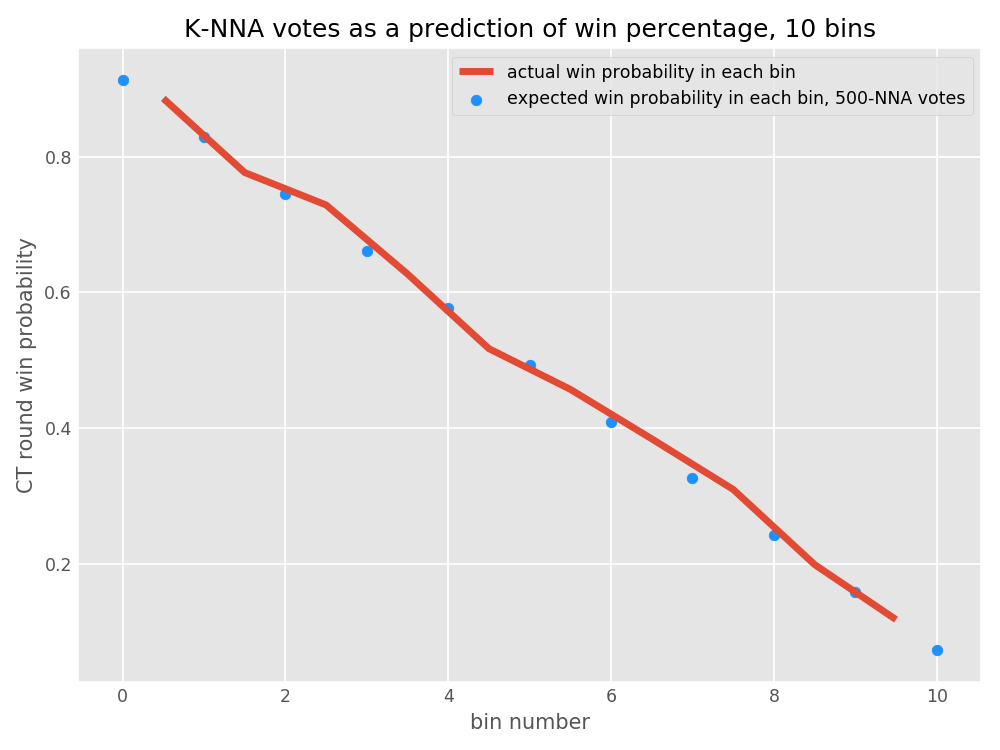

In [90]:
figure(figsize=(8, 6))

title('K-NNA votes as a prediction of win percentage, 10 bins')
xlabel('bin number')
ylabel('CT round win probability')

binxvals = np.arange(0.5,10.5,1) # add 0.5 because it should actually be a histogram and thus in the centre of the bin
plot(binxvals, actualwinrates, label='actual win probability in each bin')

binxvals = np.arange(10,-1,-1)
scatter(binxvals, bins, color='dodgerblue', label='expected win probability in each bin, 500-NNA votes')
legend()
tight_layout()
show()

### Analysis

We grouped our samples into 10-percentile 'bins' according to the probabilistic prediction our model created from taking the number of votes for that class and dividing by _K_. 

This allowed us to evaluate whether or not a bin's samples demonstrated any semblance of stochastic predictive power.  

### Conclusion


My hypothesis that we would be able to accurately gauge the likelihood a subgame will fall into a particular class by polling the votes proved to be correct. Since the bin's predicted win probabilities correlate very strongly with the observed win percentage in that bin we can be very confident that this hypothesis was correct.

# Discussion:

In this exploratory report into _CS:GO_ analytics, we examined two models for predicting the results of subgames of matches: _ our self-built Persistence Model and sk-learn's K-Nearest-Neighbor's Algorithm. We utilized two of Sci-py's statistical significance tests to distinguish two samples and verify a hypothesis and Matplotlib to display our data/findings. We made heavy use of Pandas to store and handle our data. We experimented with creating new series (columns) based on functions of other series and adding series of new information to our pandas dataframes.

Functional programming was used to maximise the re-usability of our code on new data or in future models which aggregate others. This is particularly important given my intention to use the report as a stepping stone leading to more powerful models. All of the analysis was performed on one map, _mirage_, however running a simple function will change the data file to allow the similar analysis of other maps in the dataset. 

Some of our notable findings include the discovery that the _second_ round was - contrary to popular belief - a better predictor of the subsequent round than the first and that 'de_mirage' is the most balanced map.

We showed that simply feeding models more data is not a recipe for more accurate classification, particularly for the K-NNA , which is sensitive to increasing dimensionality.  

Our more advanced work involved utilizing the K-NNA to create statistical predictions - a significant step towards more holistic analyses of entire matches.

## Future work & further reading:

I am a firm believer that the K-NNA is a strong tool for this type of analysis. Further work ought to use the model with a suitale value of K  to bin the _economic_ outcomes of the subgames. This is the next logical step towards a functional _Markov model_ of CS:GO matches. 

Those with an interest may wish to read: 

[[A look at in-round statistics and round-win predictors:](
https://www.reddit.com/r/GlobalOffensive/comments/6tom6c/a_look_at_advanced_statistics_in_csgo/)]

In [111]:
import io
from IPython.nbformat import current

with io.open("C:\\Users\\Extasia\\Final Report.ipynb", 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(word_count)

4190


## References:

1)https://en.wikipedia.org/wiki/Counter-Strike, last accessed: 6/1/2019

2)https://www.dartmouth.edu/~chance/teaching_aids/books_articles/probability_book/Chapter11.pdf

3)https://www.washingtonpost.com/sports/esports-bookmaking-globally-its-already-a-billion-dollar-gambling-industry/2018/04/06/be89c282-2b99-11e8-8688-e053ba58f1e4_story.html?noredirect=on&utm_term=.1284c20eac45, last accessed: 6/1/2019

4)https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage, last accessed: 6/1/2019

5)https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.htl, last accessed: 6/1/2019
6)https://arxiv.org/pdf/1110.4347v2.pdf
7)https://www.academia.edu/30642706/Usage_of_Principal_Component_Analysis_PCA_in_AI_Applications

#### Joseph S. Boyle.